In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from src.utilities import Matrix

from src.observables import entropy_vn, covariance_invariants, symplectic_eigenvalues, symplectic_eigenvalues_transposed, symplectic_entropy, mutual_information, gaussian_quantum_discord, logarithmic_negativity

SUFFIX = '.npy'

In [2]:
# Files utilities

def file_dims(filename):
    return int(filename.split('_')[-3][1:])


def file_time(filename):
    return int(filename.split('_')[-2][1:])


def file_timedelta(filename):
    return float(filename.split('_')[-1][2:])


def check_file_metadata(filename, d, dt):
    dims = file_dims(filename)
    timedelta = file_timedelta(filename)
    return dims == d and timedelta == dt


def get_all_files(state, observable):
    files = [file for file in os.listdir(f'../objects/{state}') if file.endswith(SUFFIX) and file.startswith(f'rho_{observable}')]
    return files

def get_cov_of_dims(dims, state) -> dict:
    files = {file_timedelta(file.removesuffix('.npy')): file for file in os.listdir(f'../objects/{state}') if file.endswith(SUFFIX) and file.startswith(f'rho_covariance_D{dims}')}
    return dict(sorted(files.items()))

# Effects of Interaction Time on the evolution

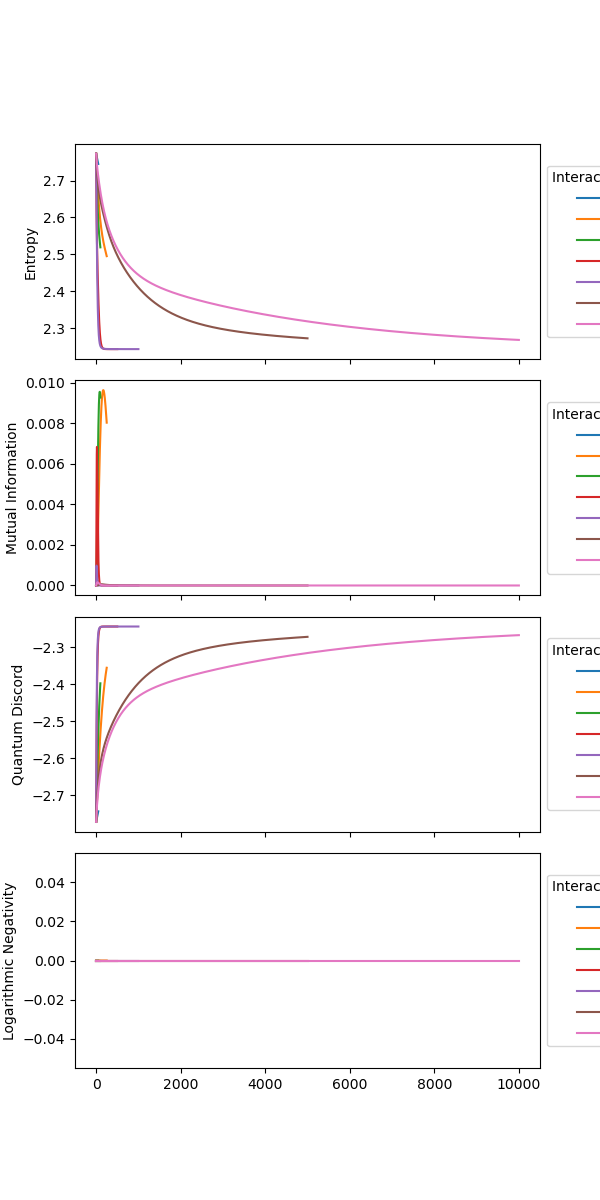

In [33]:
observables = ['Entropy', 'Mutual Information', 'Quantum Discord', 'Logarithmic Negativity']
df = pd.DataFrame(columns=observables)
fig, axs = plt.subplots(len(observables), 1, figsize=(6, 12), sharex='all')
state = 'thermal'
cov_files = get_cov_of_dims(20, state)
for timedelta, file in cov_files.items():
    dt_df = pd.DataFrame(columns=observables)
    cov_evolution = np.load(f'../objects/{state}/' + file)
    time = [i * timedelta for i in range(len(cov_evolution))]
    # Find symplectic eigenvalues from covariance invariants
    nus_evolution = [symplectic_eigenvalues(cov) for cov in cov_evolution]
    entropy_evolution = np.array([symplectic_entropy(cov) for cov in cov_evolution]).real
    mut_inf_evolution = np.array([mutual_information(cov) for cov in cov_evolution]).real
    discord_evolution = np.array([gaussian_quantum_discord(cov) for cov in cov_evolution]).real
    logneg_evolution = np.array([logarithmic_negativity(cov) for cov in cov_evolution]).real
    axs[0].plot(time, entropy_evolution, label=f'{timedelta}')
    axs[1].plot(time, mut_inf_evolution, label=f'{timedelta}')
    axs[2].plot(time, discord_evolution, label=f'{timedelta}')
    axs[3].plot(time, logneg_evolution, label=f'{timedelta}')
    dt_df['Entropy'] = entropy_evolution
    dt_df['Mutual Information'] = mut_inf_evolution
    dt_df['Quantum Discord'] = discord_evolution
    dt_df['Logarithmic Negativity'] = logneg_evolution
    dt_df['Time'] = time
    dt_df['Timedelta'] = timedelta
    df = pd.concat([df, dt_df])
plt.subplots_adjust(hspace=0.1)
# Title each subplot
for i, title in enumerate(observables):
    axs[i].set_ylabel(title)
# Put a legend to the right of the current axis
for i in range(len(observables)):
    axs[i].legend(title='Interaction times',
                  loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
fig = make_subplots(rows=len(observables), cols=1)

fig.add_trace(go.Scatter(df, x='Time', y='Entropy', color='Timedelta', name='Entropy'), row=1, col=1)
fig.add_trace(go.Scatter(x=time, y=mut_inf_evolution, name='Mutual Information'), row=2, col=1)
fig.add_trace(go.Scatter(x=time, y=discord_evolution, name='Quantum Discord'), row=3, col=1)
fig.add_trace(go.Scatter(x=time, y=logneg_evolution, name='Logarithmic Negativity'), row=4, col=1)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

ValueError: The first argument to the plotly.graph_objs.Scatter
constructor must be a dict or
an instance of :class:`plotly.graph_objs.Scatter`

In [28]:
fig_entropy = px.line(df, x='Time', y='Entropy', color='Timedelta', title='Entropy')
fig_entropy.show()

In [34]:
fig_discord = px.line(df, x='Time', y='Quantum Discord', color='Timedelta', title='Quantum Discord')
fig_discord.show()

In [35]:
fig_mutinf = px.line(df, x='Time', y='Mutual Information', color='Timedelta', title='Mutual Information')
fig_mutinf.show()

In [36]:
fig_logneg = px.line(df, x='Time', y='Logarithmic Negativity', color='Timedelta', title='Logarithmic Negativity')
fig_logneg.show()